<a href="https://colab.research.google.com/github/Mancydeep/Assessment-2-weatherwise-/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyinputplus matplotlib requests

## 📦 Setup and Configuration
Import required packages and setup environment.

In [2]:
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import pyinputplus as pyip

# Add any other setup code here

## 🌤️ Weather Data Functions

In [3]:
# Define get_weather_data() function here
def get_weather_data(location, forecast_days=5):
    """
    Obtain forecast details for a selected city and duration via wttr.in, limiting the days as recommended.
    """
    endpoint = f"https://wttr.in/{location}?format=j1"
    try:
        result = requests.get(endpoint)
        result.raise_for_status()
        data = result.json()
        data['weather'] = data['weather'][:forecast_days]
        return data
    except Exception as error:
        print(f"Unable to retrieve forecast: {error}")
        return None


## 📊 Visualisation Functions

In [4]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Display max & min temperatures as stacked horizontal bars with colors.
    """
    dates = []
    max_temps = []
    min_temps = []

    for day in weather_data['weather']:
        dates.append(day['date'])
        max_temps.append(float(day['maxtempC']))
        min_temps.append(float(day['mintempC']))

    plt.figure(figsize=(8, 5))
    y_pos = range(len(dates))

    # Plot min temp as bars, then add max-min stacked over it
    plt.barh(y_pos, min_temps, color='#82CFFD', label='Min Temp (°C)')
    max_min_diff = [max_temps[i] - min_temps[i] for i in range(len(max_temps))]
    plt.barh(y_pos, max_min_diff, left=min_temps, color='#FF6F61', label='Max Temp range')

    plt.yticks(y_pos, dates)
    plt.xlabel("Temperature (°C)")
    plt.title("Temperature Range per Day")
    plt.legend()
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



In [5]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    dates = []
    totals = []

    for day in weather_data['weather']:
        dates.append(day['date'])
        total_rain = sum(float(hour['precipMM']) for hour in day['hourly'])
        totals.append(total_rain)

    x = np.arange(len(dates))
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(totals)))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(x, totals, color=colors, edgecolor='black', linewidth=0.7, alpha=0.85, width=0.6)

    plt.xticks(x, dates, rotation=30)
    plt.xlabel("Date")
    plt.ylabel("Precipitation (mm)")
    plt.title("Daily Rainfall Amount")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='black')

    plt.tight_layout()
    plt.show()


In [6]:
def create_humidity_visualisation(weather_data, output_type='display'):
    """
    Average humidity per day shown as a smooth gradient filled area chart.
    """
    dates = []
    avg_humidity = []

    for day in weather_data['weather']:
        dates.append(day['date'])
        humid_vals = [float(hour['humidity']) for hour in day['hourly']]
        avg = sum(humid_vals) / len(humid_vals)
        avg_humidity.append(avg)

    plt.figure(figsize=(8, 5))
    plt.plot(dates, avg_humidity, color='#388E3C', lw=2)

    # Color fill with gradient alpha
    for i in range(len(dates)-1):
        plt.fill_between(dates[i:i+2], avg_humidity[i:i+2], color='#A5D6A7', alpha=0.4*(i+1)/len(dates))

    plt.title("Average Daily Humidity")
    plt.xlabel("Date")
    plt.ylabel("Humidity (%)")
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()


## 🤖 Natural Language Processing

In [7]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question):
    """
    Extracts city, feature, and day from a user's weather query.
    """
    question = question.lower()
    features = ['temperature', 'precipitation']
    time_markers = ['today', 'tomorrow', 'day after tomorrow']
    city = None
    focus = None
    day_ref = 'today'

    for f in features:
        if f in question:
            focus = f
            break
    for t in time_markers:
        if t in question:
            day_ref = t
            break

    parts = question.split()
    if 'in' in parts:
        idx = parts.index('in')
        if idx + 1 < len(parts):
            city = parts[idx + 1]
    else:
        city = 'Perth'
    return {'city': city, 'element': focus, 'period': day_ref}


## 🧩 Main Application Logic

In [8]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a text response for temperature, precipitation, or humidity forecast.
    """
    city = parsed_question.get('city', 'Unknown').title()
    element = parsed_question.get('element')
    period = parsed_question.get('period', 'today').lower()

    day_index = 0
    if period == 'tomorrow':
        day_index = 1
    elif period == 'day after tomorrow':
        day_index = 2

    try:
        day = weather_data['weather'][day_index]
        if element in [None, 'temperature']:
            high = day.get('maxtempC')
            low = day.get('mintempC')
            return f"In {city} on {day['date']}, temperatures will range between {low}°C and {high}°C."
        elif element in ['precipitation', 'rain']:
            total_rain = sum(float(hour['precipMM']) for hour in day['hourly'])
            return f"In {city} on {day['date']}, total precipitation is expected to be {total_rain:.1f} mm."
        elif element == 'humidity':
            avg_humidity = sum(float(hour['humidity']) for hour in day['hourly']) / len(day['hourly'])
            return f"In {city} on {day['date']}, average humidity will be {avg_humidity:.1f}%."
        else:
            return "Sorry, only temperature, precipitation, and humidity data are supported."
    except (IndexError, KeyError, TypeError):
        return "Sorry, weather data is not available for the requested time."


## 🧭 User Interface

=== Weather Hub ===

Choose an option below:
1 - Ask Weather Question
2 - Temperature Chart
3 - Precipitation Chart
4 - Humidity Chart
5 - Exit
Enter your option (1-5): 1
Enter your city name: sydney
Type your weather question: weather today
In Sydney on 2025-10-17, temperatures will range between 17°C and 32°C.
=== Weather Hub ===

Choose an option below:
1 - Ask Weather Question
2 - Temperature Chart
3 - Precipitation Chart
4 - Humidity Chart
5 - Exit
Enter your option (1-5): 2
Enter your city name: sydney


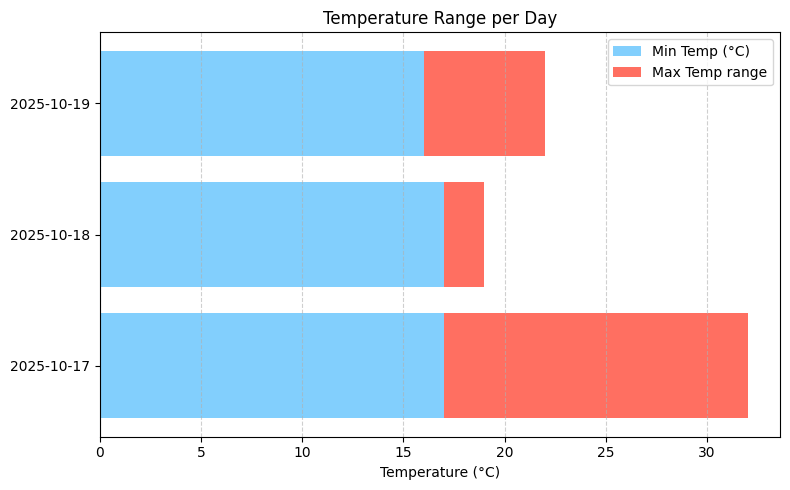

=== Weather Hub ===

Choose an option below:
1 - Ask Weather Question
2 - Temperature Chart
3 - Precipitation Chart
4 - Humidity Chart
5 - Exit
Enter your option (1-5): 3
Enter your city name: perth


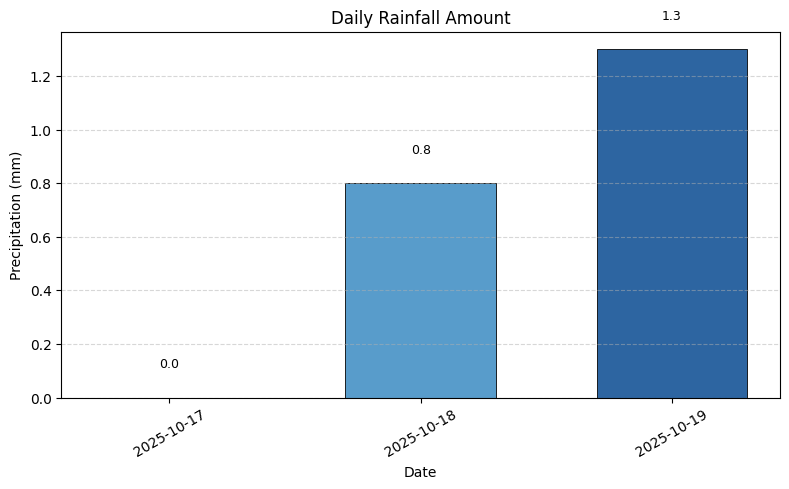

=== Weather Hub ===

Choose an option below:
1 - Ask Weather Question
2 - Temperature Chart
3 - Precipitation Chart
4 - Humidity Chart
5 - Exit
Enter your option (1-5): 4
Enter your city name: perth


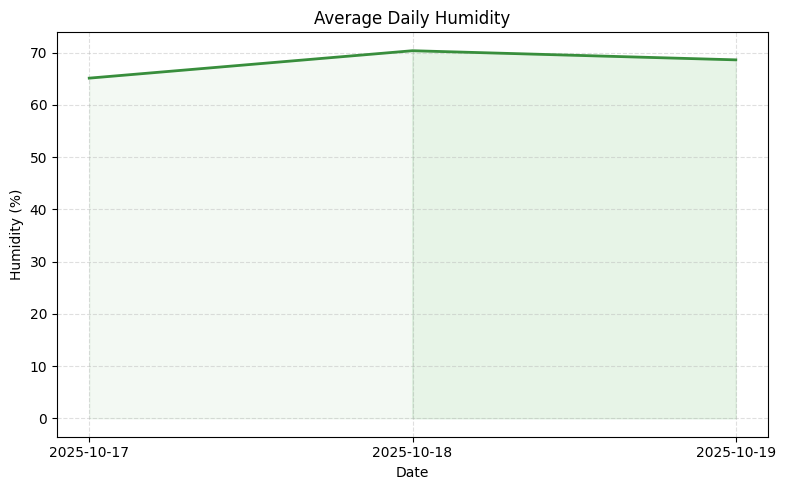

=== Weather Hub ===

Choose an option below:
1 - Ask Weather Question
2 - Temperature Chart
3 - Precipitation Chart
4 - Humidity Chart
5 - Exit
Enter your option (1-5): 

In [ ]:
# Define menu functions using pyinputplus or ipywidgets here
def weather_menu():
    print("=== Weather Hub ===")
    print("\nChoose an option below:")
    print("1 - Ask Weather Question")
    print("2 - Temperature Chart")
    print("3 - Precipitation Chart")
    print("4 - Humidity Chart")
    print("5 - Exit")

    choice = pyip.inputChoice(['1', '2', '3', '4', '5'], prompt="Enter your option (1-5): ")

    if choice == '5':
        print("Thank you for using Weather Hub! Goodbye.")
        return

    city = pyip.inputStr(prompt="Enter your city name: ")
    data = get_weather_data(city, forecast_days=3)
    if not data:
        print("Weather data unavailable. Please try again.")
        weather_menu()  # recursive call to reload menu
        return

    if choice == '1':
        question = pyip.inputStr(prompt="Type your weather question: ")
        parsed = parse_weather_question(question)
        parsed['city'] = city
        print(generate_weather_response(parsed, data))
    elif choice == '2':
        create_temperature_visualisation(data)
    elif choice == '3':
        create_precipitation_visualisation(data)
    elif choice == '4':
        create_humidity_visualisation(data)

    # Recursive call to keep showing menu after each action
    weather_menu()

# Initial call to start menu
weather_menu()






## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.